![Machine Learning Lab](banner.jpg)

# Laboratorio 3

## Objetivos

1. **Exploración de Support Vector Machines (SVM)**: Analizar el comportamiento de diferentes kernels (linear, RBF, polynomial, sigmoid) en datos no linealmente separables.

2. **Procesamiento del dataset de fraude**: Cargar y explorar el dataset de transacciones fraudulentas con tarjetas de crédito.

3. **Implementación de pipelines**: Crear pipelines combinando StandardScaler y SVC para clasificación de fraudes.

4. **Evaluación de modelos**: Analizar el rendimiento usando matrices de confusión y métricas de clasificación.

5. **Optimización de hiperparámetros**: Aplicar Grid Search para encontrar los mejores parámetros del modelo SVM.

## Descarga de datasets

Antes de comenzar, descarguemos los datasets necesarios para el laboratorio. Estos datasets incluyen información sobre fraudes con tarjetas de crédito.

In [1]:
!mkdir datasets
!curl -L -o datasets/creditcardfraud.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud
!unzip datasets/creditcardfraud.zip -d datasets/creditcardfraud
!ls datasets/creditcardfraud

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  26.1M      0  0:00:02  0:00:02 --:--:-- 30.4M  0  0:00:10  0:00:01  0:00:09 8539k
Archive:  datasets/creditcardfraud.zip
  inflating: datasets/creditcardfraud/creditcard.csv  
creditcard.csv


## Cargar librerias

Importamos las librerías necesarias para usar Support Vector Machines (SVM)

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Support Vector Machines (SVC) y la utilidad de los kernels

### 1.1. Exploración datos sintéticos

Empezaremos exploremos el uso de SVC sobre datos sintéticos.



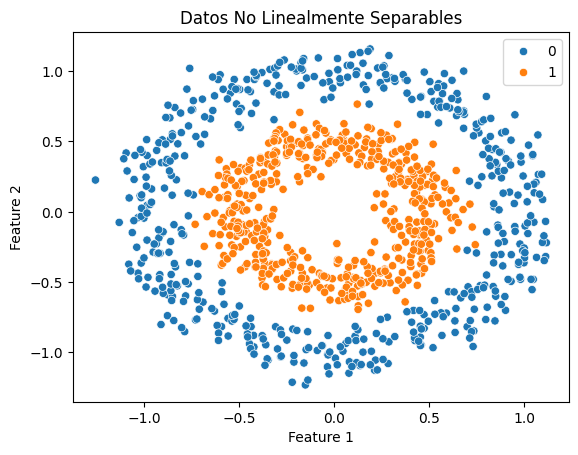

In [3]:
# Generar datos que no sean linealmente separables
X_random, y_random = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)

# Visualizar los datos
sns.scatterplot(x=X_random[:, 0], y=X_random[:, 1], hue=y_random)
plt.title("Datos No Linealmente Separables")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Como se puede ver estos datos no son separables linealmente

In [4]:
def plot_frontier_svc(X_, y_, kernel="linear", C=1):
    """
    Grafica la frontera de decisión de un clasificador de Máquina de Vectores de Soporte (SVM)
    utilizando conjuntos de datos de entrenamiento y prueba.
    El clasificador SVM es entrenado en la versión escalada de la matriz de características.
    La función visualiza la frontera de decisión.

    :param X_: ndarray
        La matriz de características. Estos datos deben contener únicamente 2 características,
        por ejemplo, ['Glucosa', 'Edad']

    :param y_: ndarray
        Los valores objetivo/etiquetas de clase correspondientes a las filas de la matriz
        de características de entrada.

    :param kernel: str, opcional
        Especifica el tipo de kernel a utilizar en el algoritmo SVM. Por defecto es "linear".
        Otras opciones válidas incluyen "rbf", "poly", "sigmoid", etc.

    :param C: float, opcional
        Parámetro de regularización. La fuerza de la regularización es inversamente
        proporcional a C. Valor por defecto es 1.
    """

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_)

    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_scaled, y_, test_size=0.2, random_state=31)

    svm = SVC(kernel=kernel, C=C)
    svm.fit(X_train_, y_train_)

    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    train_df = pd.DataFrame({
        'x': X_train_[:, 0],
        'y': X_train_[:, 1],
        'class': y_train_,
        'set': 'train'
    })
    test_df = pd.DataFrame({
        'x': X_test_[:, 0],
        'y': X_test_[:, 1],
        'class': y_test_,
        'set': 'test'
    })
    df = pd.concat([train_df, test_df])

    sns.scatterplot(data=df, x='x', y='y', hue='class', style='set')
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(f"Frontera de Decisión del SVM kernel: {kernel} C:{C}")
    plt.legend()
    plt.show()

Veamos entonces como afecta la frontera de desicion usar distintos kernels

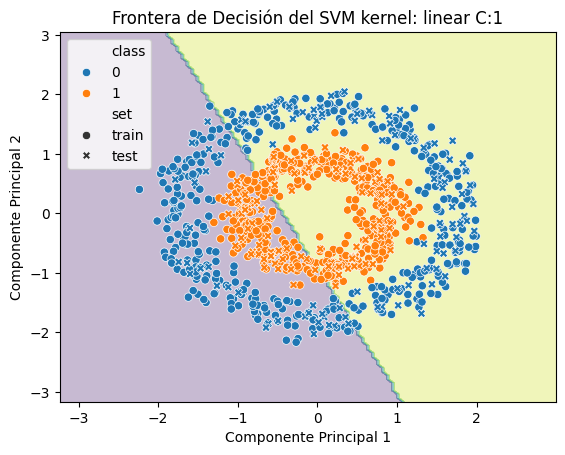

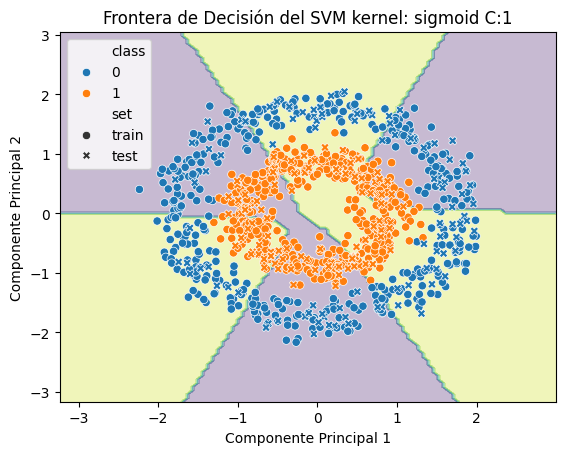

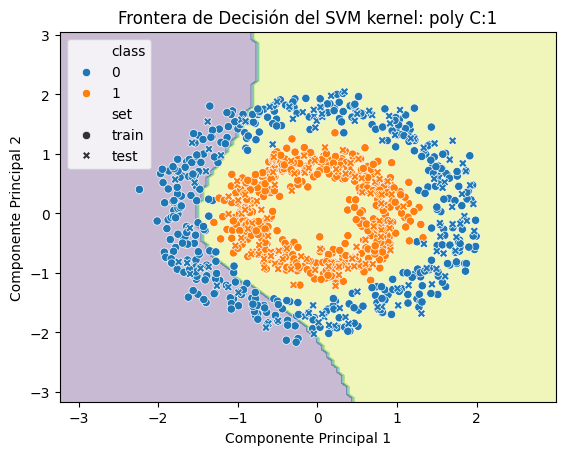

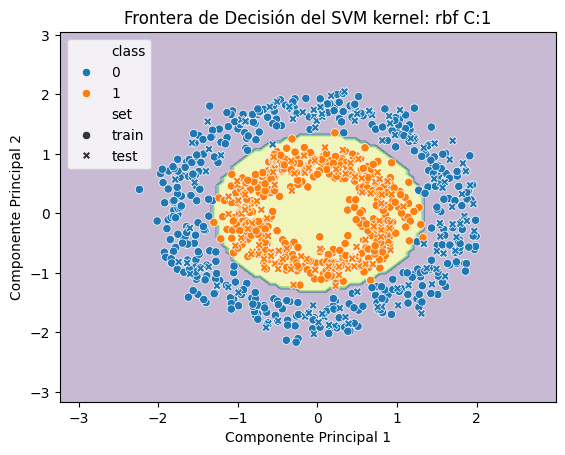

In [5]:
plot_frontier_svc(X_random, y_random, kernel="linear", C=1)
plot_frontier_svc(X_random, y_random, kernel="sigmoid", C=1)
plot_frontier_svc(X_random, y_random, kernel="poly", C=1)
plot_frontier_svc(X_random, y_random, kernel="rbf", C=1)

## 2.0. Exploración dataset

### Descripción del Dataset de Fraude en Tarjetas de Crédito

El dataset que utilizaremos contiene transacciones realizadas con tarjetas de crédito durante septiembre de 2013 por portadores de tarjetas europeos. Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 casos de fraude de un total de 284,807 transacciones.

**Características principales del dataset:**

- **Variables numéricas**: Contiene únicamente variables de entrada numéricas que son el resultado de una transformación PCA (Análisis de Componentes Principales). Debido a cuestiones de confidencialidad, no se pueden proporcionar las características originales ni más información contextual sobre los datos.

- **Características transformadas**: Las características V1, V2, ..., V28 son los componentes principales obtenidos con PCA.

- **Características no transformadas**:
  - **'Time'**: Contiene los segundos transcurridos entre cada transacción y la primera transacción en el dataset.
  - **'Amount'**: Es el monto de la transacción.

- **Variable objetivo**: La característica **'Class'** es la variable de respuesta que toma el valor 1 en caso de fraude y 0 en caso contrario.

In [6]:


fraud_data = pd.read_csv("datasets/creditcardfraud/creditcard.csv")

# Explorar el dataset
print(fraud_data.head())
print(fraud_data.info())
print(fraud_data['Class'].value_counts())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

### 2.1. Separación de los datos

Separamos los datos en sets de entrenamiento y testing


In [7]:


# Separar características (X) y etiquetas (y)
X = fraud_data.drop('Class', axis=1)
y = fraud_data['Class']

# Dividir el dataset en entrenamiento y prueba usando 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### 2.2. Crear un pipeline con StandardScaler y SVC

StandardScaler normaliza los datos, asegurando que todas las características tengan la misma escala , lo que es crucial para SVC, ya que es sensible a las diferencias de magnitud entre características. Tener en cuenta que la proxima celda puede tardarse aproximadamente 10 minutos en completarse.

In [8]:


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.80      0.74      0.77       148

    accuracy                           1.00     85443
   macro avg       0.90      0.87      0.88     85443
weighted avg       1.00      1.00      1.00     85443


Precisión del modelo: 0.9992275552122467


### 2.3. Matriz de confusión

La matriz de confusión nos permite visualizar de forma clara el rendimiento del clasificador, mostrando la relación entre las predicciones y los valores reales.

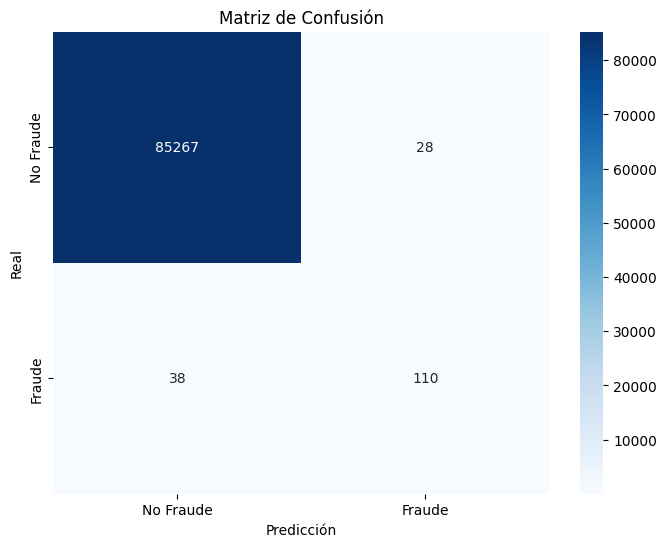

In [9]:


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### 2.4. Optimización de hiperparámetros

De acuerdo a lo mostrado al comienzo del laboratorio veamos si realizar cambios al kernel o la normalización puede mejorar el modelo. Debido al tamaño del dataset solo haremos GridSearch sobre una fracción de estos. Esta celda puede demorar en ejecutarse media hora.

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True))
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train.iloc[:50000], y_train.iloc[:50000])

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Reporte de Clasificación (Mejor Modelo):")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros: {'svc__C': 100, 'svc__kernel': 'linear'}
Mejor puntuación: 0.9995800000000001
Reporte de Clasificación (Mejor Modelo):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.66      0.74       148

    accuracy                           1.00     85443
   macro avg       0.93      0.83      0.87     85443
weighted avg       1.00      1.00      1.00     85443



Aplicamos el modelo optimizado con los mejores hiperparámetros encontrados por Grid Search en todo el conjunto de prueba.

Visualizamos los resultados finales del modelo optimizado mediante una nueva matriz de confusión.

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', C=100))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()